In [36]:
#import packages
import pandas as pd
import numpy as np
import random
import re
import string
#import requests
#import plotnine 
#from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats



# Data Prep

## Load in Data

In [37]:
# Define the file path
pre_file_path = '../code/data/Med student pre assessment 2.8.23.csv'
foundational_file_path = '../code/data/Foundational Post Assessment 2.8.23.csv'
intermediate_file_path = '../code/data/intermediate post assessment 2.8.23.csv'
advanced_file_path = '../code/data/Advanced post assessment 2.8.23.csv'

# Load the datasets using pandas
pre_data = pd.read_csv(pre_file_path)
post_data_foundational = pd.read_csv(foundational_file_path,skiprows =lambda x: x in [1,2])
post_data_intermediate = pd.read_csv(intermediate_file_path,skiprows =lambda x: x in [1,2])
post_data_advanced = pd.read_csv(advanced_file_path,skiprows =lambda x: x in [1,2])


## Merge Data

In [38]:
#merge pre to foundational post, where scox = pre score, scoy = post score
joined_data_foundational = pd.merge(post_data_foundational, pre_data, on = "IPAddress", how = "left")
joined_data_intermediate = pd.merge(post_data_intermediate, pre_data, on = "IPAddress", how = "left")
joined_data_advanced = pd.merge(post_data_advanced, pre_data, on = "IPAddress", how = "left")


## Rename columns

In [39]:
#renaming the columns, SC0y = pre, SC0x = post for clarity:
foundational_data = joined_data_foundational.rename(columns={'SC0_y':'Pre', 'SC0_x':'Post'})
#drop missing data from Pre and Post
foundational_data = foundational_data.dropna(subset=['Pre', 'Post'])

#do the same for two other cohorts
intermediate_data = joined_data_intermediate.rename(columns={'SC0_y':'Pre', 'SC0_x':'Post'})
intermediate_data = intermediate_data.dropna(subset=['Pre', 'Post'])

advanced_data = joined_data_advanced.rename(columns={'SC0_y':'Pre', 'SC0_x':'Post'})
advanced_data = advanced_data.dropna(subset=['Pre', 'Post'])

# Code for Sentiment Analysis

In [40]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader=SentimentIntensityAnalyzer()

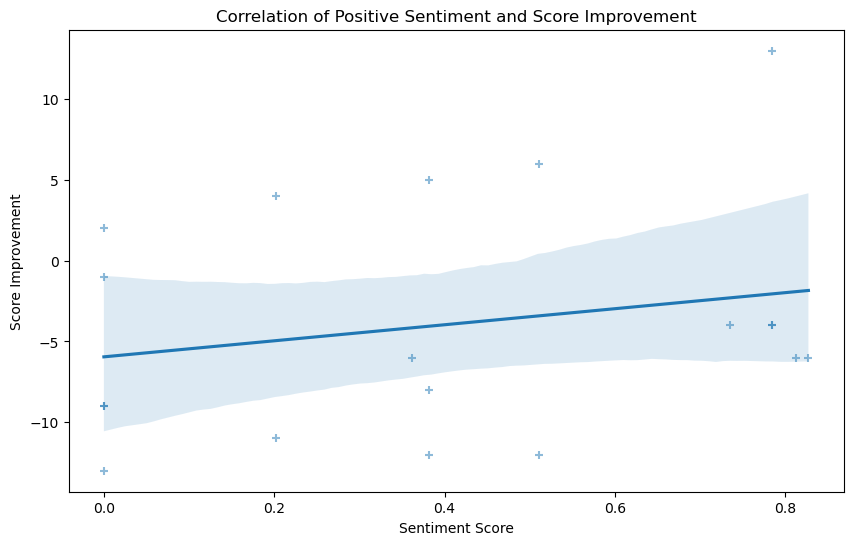

In [41]:
#data loading and preparation
satisfaction_file_path = 'data/module satisfaction evaluations 2.8.23.csv'
satisfaction_df = pd.read_csv(satisfaction_file_path, skiprows=lambda x: x in [1, 2])
satisfaction_df = satisfaction_df[['Q3', 'Q2', 'IPAddress']].rename(columns={'Q3': 'What was most helpful', 'Q2': 'Overall Course Satisfaction'}).dropna()

#merge data
advanced_sat = pd.merge(advanced_data.drop_duplicates(subset=['IPAddress']), satisfaction_df.drop_duplicates(subset=['IPAddress']), on='IPAddress', how='left')
intermediate_sat = pd.merge(intermediate_data.drop_duplicates(subset=['IPAddress']), satisfaction_df.drop_duplicates(subset=['IPAddress']), on='IPAddress', how='left')
foundational_sat = pd.merge(foundational_data.drop_duplicates(subset=['IPAddress']), satisfaction_df.drop_duplicates(subset=['IPAddress']), on='IPAddress', how='left')

#assign cohorts
advanced_sat['Cohort'] = 'advanced'
intermediate_sat['Cohort'] = 'intermediate'
foundational_sat['Cohort'] = 'foundational'
combined_sat = pd.concat([advanced_sat, intermediate_sat, foundational_sat], ignore_index=True)

#sentiment analysis
vader = SentimentIntensityAnalyzer()
combined_sat['sentiment_score'] = [vader.polarity_scores(text)['compound'] if pd.notna(text) else np.nan for text in combined_sat['What was most helpful']]
combined_sat['SC0 Improvement'] = combined_sat['Post'].astype(int) - combined_sat['Pre'].astype(int)

#plotting the regression plot
plt.figure(figsize=(10, 6))
sns.regplot(x='sentiment_score', y='SC0 Improvement', data=combined_sat, fit_reg=True, marker='+', scatter_kws={'alpha':0.5})
plt.title('Correlation of Positive Sentiment and Score Improvement')
plt.xlabel('Sentiment Score')
plt.ylabel('Score Improvement')
#plt.savefig('combined_sentiment_correlation.png')
plt.show()


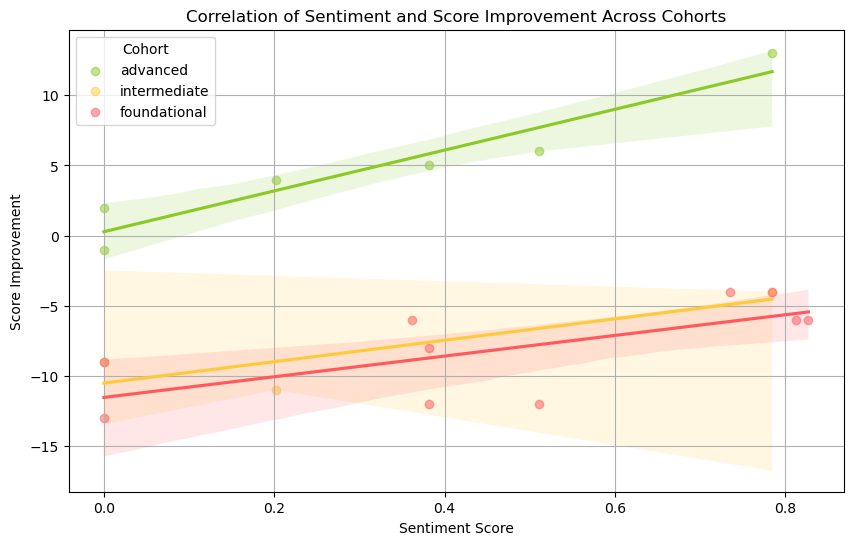

In [42]:


#calculate sentiment scores
combined_sat['sentiment_score'] = [vader.polarity_scores(text)['compound'] if pd.notna(text) else np.nan for text in combined_sat['What was most helpful']]
combined_sat['SC0 Improvement'] = combined_sat['Post'].astype(int) - combined_sat['Pre'].astype(int)

#define cohort colors
cohort_colors = {
    'advanced': '#8ac926',  # green
    'intermediate': '#ffca3a',  # yellow
    'foundational': '#ff595e'  # red
}

#create regression plots for each cohort with customized colors
plt.figure(figsize=(10, 6))
for cohort, color in cohort_colors.items():
    sns.regplot(data=combined_sat[combined_sat['Cohort'] == cohort],
                x='sentiment_score', y='SC0 Improvement', color=color, label=cohort, scatter_kws={'alpha': 0.5})

#add titles and labels
plt.title('Correlation of Sentiment and Score Improvement Across Cohorts')
plt.xlabel('Sentiment Score')
plt.ylabel('Score Improvement')
plt.legend(title='Cohort')
plt.grid(True)
#plt.savefig('cohort_sentiment_regression.png')
plt.show()
